## Preprocess

In [5]:
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [6]:
data_dir = "./data/augumented_data/"
labels_dirs = os.listdir(data_dir)
choosen_labels = []

images = []
labels = []

for label in labels_dirs:
    if label == ".DS_Store":
        continue
    label_path = os.path.join(data_dir, label)
    images_dir = os.listdir(label_path)
    choosen_labels.append((label, len(images_dir)))
choosen_labels.sort(key=lambda x: x[1], reverse=True)
choosen_labels = choosen_labels[:2]
min_count = choosen_labels[-1][1]

for label, count in choosen_labels:
    label_path = os.path.join(data_dir, label)
    images_dir = os.listdir(label_path)
    for image in images_dir[:min_count]:
        image_path = os.path.join(label_path, image)
        img = cv2.imread(image_path)
        images.append(img)
        labels.append(label)


In [7]:
images = images[:500] + images[-500:]
labels = labels[:500] + labels[-500:]

In [8]:
images_reshaped = []
for image in images:
    resized_image = cv2.resize(image, (256, 256))
    images_reshaped.append(resized_image)

In [9]:
labels = np.array(labels)
images = np.array(images_reshaped)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

del images, images_reshaped
print(len(X_test), len(X_train), len(X_val))
print(np.sum(y_test == 'tumor'), np.sum(y_train == 'tumor'), np.sum(y_val == 'tumor'))

200 600 200
100 300 100


In [11]:
# mean_train = np.mean(X_train, axis=(0, 1, 2))
# std_train = np.std(X_train, axis=(0, 1, 2))

# mean_test = np.mean(X_test, axis=(0, 1, 2))
# std_test = np.std(X_test, axis=(0, 1, 2))

# X_train = (X_train - mean_train) / std_train
# X_test = (X_test - mean_test) / std_test
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [12]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

y_train = y_train.toarray()
y_val = y_val.toarray()
y_test = y_test.toarray()

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

labels = encoder.categories_[0]
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

print(encoder.get_feature_names_out())

['x0_normal' 'x0_tumor']


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [14]:
X_train = X_train.transpose((0, 3, 1, 2))
X_val = X_val.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [15]:
print(X_train.dtype)
print(y_train.dtype)

float32
float32


In [16]:
print(X_train.shape)

(600, 3, 256, 256)


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(524288, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = self.flat(x)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [14]:

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
model = SimpleCNN()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


n_epochs = 5
min_valid_loss = np.inf
 
for e in range(n_epochs):
    train_loss = 0.0
    for data, labels in train_loader:
         
        optimizer.zero_grad()
        target = model(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
     
    valid_loss = 0.0
    model.eval()
    for data, labels in validation_loader:
         
        target = model(data)
        loss = criterion(target,labels)
        valid_loss += loss.item()
 
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
         
        torch.save(model.state_dict(), 'saved_model.pth')

Epoch 1 		 Training Loss: 0.6934354424476623 		 Validation Loss: 0.6931471824645996
Validation Loss Decreased(inf--->2.772589) 	 Saving The Model
Epoch 2 		 Training Loss: 0.6931471824645996 		 Validation Loss: 0.6931471824645996
Epoch 3 		 Training Loss: 0.6931471824645996 		 Validation Loss: 0.6931471824645996
Epoch 4 		 Training Loss: 0.6931471824645996 		 Validation Loss: 0.6931471824645996
Epoch 5 		 Training Loss: 0.6931471824645996 		 Validation Loss: 0.6931471824645996


### CAM

In [18]:
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchcam.utils import overlay_mask

In [19]:
img_path = "data/augumented_data/tumor/Cancer (1).jpg"

In [20]:
model = SimpleCNN()
model.load_state_dict(torch.load('./saved_model.pth'))

<All keys matched successfully>

In [30]:
class GradCamModel():
    def __init__(self, model) -> None:
        self.model = model.eval()
        self.cam_extractor = GradCAM(self.model, input_shape=(3, 256, 256))

    def get_img(self, img_path):
        img = cv2.imread(img_path)
        img = torch.tensor(img.transpose(2, 0, 1)).float()
        return img

    def get_cams(self, img_path):
        img = self.get_img(img_path)
        input_tensor = normalize(resize(img, (256, 256)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        out = self.model(input_tensor.unsqueeze(0))
        cams = self.cam_extractor(out.squeeze(0).argmax().item(), out)
        return cams
    
    def show_cams(self, cams, img_path):
        img = self.get_img(img_path)
        for name, cam in zip(self.cam_extractor.target_names, cams):
            result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
            plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()
        self.cam_extractor.remove_hooks()        

In [31]:
CAM = GradCamModel(model)

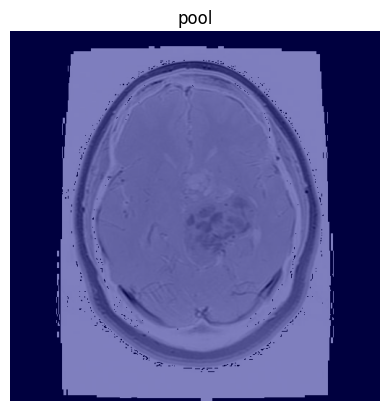

In [32]:
cams = CAM.get_cams(img_path)
CAM.show_cams(cams, img_path)